# Value of Plays Using Run Expectancy

## The Run Expectancy Matrix

The **run expectancy matrix** is a fundamental sabermetrics concept that calculates the average number of runs expected to score for each game state (combination of baserunners and outs).

**Key concepts:**
- 8 possible base states (each of 3 bases can be empty or occupied: 2³ = 8)
- 3 possible out states (0, 1, or 2 outs)
- **24 total game states** (8 × 3 = 24)

## Runs Scored in the Remainder of the Inning

$$\text{runs}_{\text{roi}} = \text{runs}_{\text{Total in Inning}} - \text{runs}_{\text{So far in Inning}}$$

This calculates how many runs will be scored from the current game state until the end of the inning.

### Data Source

Using Retrosheet play-by-play data for the 2016 MLB season. Each row represents a single plate appearance with detailed information about the game state, players involved, and the outcome of the play.

In [1]:
import pandas as pd
fields = pd.read_csv('../data/fields.csv')
headers = fields['Header'].str.lower().tolist()

retro2016 = pd.read_csv('../data/all2016.csv', names=headers, low_memory=False)

In [2]:
# Calculate total runs scored before each plate appearance
retro2016['runs_before'] = retro2016['away_score_ct'] + retro2016['home_score_ct']

# Create unique identifier for each half inning (game_id + inning + batting team)
retro2016['half_inning'] = retro2016[['game_id', 'inn_ct', 'bat_home_id']].astype(str).agg(' '.join, axis=1)

In [3]:
# Calculate runs scored on each play (count runners who reached base > 3, meaning they scored)
retro2016['runs_scored'] = (
    (retro2016['bat_dest_id'] > 3).astype(int) + 
    (retro2016['run1_dest_id'] > 3).astype(int) + 
    (retro2016['run2_dest_id'] > 3).astype(int) + 
    (retro2016['run3_dest_id'] > 3).astype(int)
)

In [4]:
# Group by half inning and calculate totals for outs and runs
half_innings = retro2016.groupby('half_inning').agg({
    'event_outs_ct': 'sum',
    'runs_scored': 'sum',
    'runs_before': 'first'
}).reset_index()

# Rename columns
half_innings.columns = ['half_inning', 'outs_inning', 'runs_inning', 'runs_start']

# Calculate total runs at end of half inning
half_innings['max_runs'] = half_innings['runs_inning'] + half_innings['runs_start']

In [5]:
# Merge retro2016 with half_innings data to get inning totals
retro2016 = retro2016.merge(half_innings, on='half_inning', how='inner')

# Calculate runs scored in remainder of inning from current game state
retro2016['runs_roi'] = retro2016['max_runs'] - retro2016['runs_before']

## Creating the Matrix

Now that runs scored in the remainder of each inning (`runs_roi`) have been calculated, the run expectancy matrix can be built out.

**Creating the game state variable:**
- Combine baserunner positions into a 3-digit code
- Add the number of outs to create complete game states
- Examples:
  - "011 2" = runners on 2nd and 3rd with 2 outs
  - "100 0" = runner on 1st with 0 outs

In [6]:
import numpy as np

# Create bases code: 3-digit string indicating which bases are occupied or empty
retro2016['bases'] = (
    np.where(retro2016['base1_run_id'].notna() & (retro2016['base1_run_id'] != ''), '1', '0') +
    np.where(retro2016['base2_run_id'].notna() & (retro2016['base2_run_id'] != ''), '1', '0') +
    np.where(retro2016['base3_run_id'].notna() & (retro2016['base3_run_id'] != ''), '1', '0')
)

# Combine bases and outs to create game state
retro2016['state'] = retro2016['bases'] + ' ' + retro2016['outs_ct'].astype(str)

In [7]:
# Determine which bases are occupied after each play
retro2016['is_runner1'] = (
    (retro2016['run1_dest_id'] == 1) | (retro2016['bat_dest_id'] == 1)
).astype(int)

retro2016['is_runner2'] = (
    (retro2016['run1_dest_id'] == 2) | 
    (retro2016['run2_dest_id'] == 2) | 
    (retro2016['bat_dest_id'] == 2)
).astype(int)

retro2016['is_runner3'] = (
    (retro2016['run1_dest_id'] == 3) | 
    (retro2016['run2_dest_id'] == 3) |
    (retro2016['run3_dest_id'] == 3) | 
    (retro2016['bat_dest_id'] == 3)
).astype(int)

# Calculate outs and bases after the play
retro2016['new_outs'] = retro2016['outs_ct'] + retro2016['event_outs_ct']

# Create new bases code and state after the play
retro2016['new_bases'] = (
    retro2016['is_runner1'].astype(str) +
    retro2016['is_runner2'].astype(str) +
    retro2016['is_runner3'].astype(str)
)

retro2016['new_state'] = retro2016['new_bases'] + ' ' + retro2016['new_outs'].astype(str)

In [8]:
# Filter to plays where game state changed or runs were scored
changes2016 = retro2016[(retro2016['state'] != retro2016['new_state']) | 
                        (retro2016['runs_scored'] > 0)].copy()

# Filter to complete half innings only (exactly 3 outs recorded)
changes2016_complete = changes2016[changes2016['outs_inning'] == 3].copy()

In [9]:
# Calculate run expectancy for each bases/outs combination
erm_2016 = changes2016_complete.groupby(['bases', 'outs_ct']).agg(
    mean_run_value=('runs_roi', 'mean')
).reset_index()

# Display as matrix with outs as columns
erm_2016.pivot(
    index='bases', 
    columns='outs_ct', 
    values='mean_run_value'
).rename(columns=lambda x: f'Outs={x}')

outs_ct,Outs=0,Outs=1,Outs=2
bases,,,
000,0.498168,0.267903,0.106208
001,1.346979,0.936888,0.371953
010,1.133176,0.672856,0.312491
011,1.928788,1.357786,0.548168
100,0.857981,0.512134,0.220206
101,1.723270,1.195757,0.478245
110,1.444663,0.920621,0.413610
111,2.106105,1.537215,0.695272


### Comparing Run Expectancy Across Eras

To see how run expectancy values have changed over time, comparing the 2016 season values with 2002 season values.

In [10]:
# 2002 run expectancy values from Albert and Bennett (2003)
erm_2002 = pd.DataFrame({
    'OLD=0': [0.51, 1.40, 1.14, 1.96, 0.90, 1.84, 1.51, 2.33],
    'OLD=1': [0.27, 0.94, 0.68, 1.36, 0.54, 1.18, 0.94, 1.51],
    'OLD=2': [0.10, 0.36, 0.32, 0.63, 0.23, 0.52, 0.45, 0.78]
}, index=['000', '001', '010', '011', '100', '101', '110', '111'])

# Combine 2002 and 2016 values
out = erm_2016.pivot(
    index='bases',
    columns='outs_ct',
    values='mean_run_value'
).rename(columns=lambda x: f'NEW={x}')

out = pd.concat([out, erm_2002], axis=1)

out

,NEW=0,NEW=1,NEW=2,OLD=0,OLD=1,OLD=2
000,0.498168,0.267903,0.106208,0.51,0.27,0.10
001,1.346979,0.936888,0.371953,1.40,0.94,0.36
010,1.133176,0.672856,0.312491,1.14,0.68,0.32
011,1.928788,1.357786,0.548168,1.96,1.36,0.63
100,0.857981,0.512134,0.220206,0.90,0.54,0.23
101,1.723270,1.195757,0.478245,1.84,1.18,0.52
110,1.444663,0.920621,0.413610,1.51,0.94,0.45
111,2.106105,1.537215,0.695272,2.33,1.51,0.78


### Stability Over Time

These run expectancy values have remained very stable over recent baseball history. This indicates there have been few changes in the average run scoring tendencies of MLB teams between 2002 and 2016.


## Measuring Success of a Batting Play

### Calculating Run Value

The run value of a play measures its impact by comparing run expectancy before and after the play.

$$\text{RUN VALUE} = \text{RUNS}_{\text{New state}} - \text{RUNS}_{\text{Old state}} + \text{RUNS}_{\text{Scored on Play}}$$

In [11]:
# Join run expectancy values for start and end states of each play
retro2016 = (retro2016
    .merge(erm_2016[['bases', 'outs_ct', 'mean_run_value']], 
           on=['bases', 'outs_ct'], how='left')
    .rename(columns={'mean_run_value': 'rv_start'})
    .merge(erm_2016.rename(columns={'bases': 'new_bases', 'outs_ct': 'new_outs'})[['new_bases', 'new_outs', 'mean_run_value']], 
           on=['new_bases', 'new_outs'], how='left')
    .rename(columns={'mean_run_value': 'rv_end'})
    .fillna({'rv_end': 0}) 
)

# Calculate run value = change in run expectancy + runs scored
retro2016['run_value'] = retro2016['rv_end'] - retro2016['rv_start'] + retro2016['runs_scored']

## José Altuve

Looking at 2016 plate appearances to understand run values.

In [12]:
# Find Altuve's Retrosheet player ID from Lahman People table
people = pd.read_csv('../data/lahman/People.csv')
altuve_id = people[
    (people['nameFirst'] == 'Jose') & (people['nameLast'] == 'Altuve')
]['retroID'].iloc[0]

print(altuve_id)

altuj001


In [13]:
# Filter for Altuve's 2016 plate appearances using retroID
altuve = retro2016[(retro2016['bat_id'] == altuve_id) & (retro2016['bat_event_fl'] == 'T')]

How did Altuve do in his first three plate appearances this season?

In [14]:
altuve[['state', 'new_state', 'run_value']].head(3)

,state,new_state,run_value
1772,000 1,000 2,-0.161695
1798,000 1,100 1,0.244231
1818,000 1,000 2,-0.161695


- First AB: no runners on base with one out. Resulting AB was an out
- Second AB: bases were empty with one out. Resulting AB was on base with positive `run_value`
- Third AB: bases empty with one out.  Resulting AB was another out

In [15]:
altuve.groupby('bases').size().reset_index(name='N')

,bases,N
0,000,417
1,001,24
2,010,60
3,011,18
4,100,128
5,101,22
6,110,40
7,111,8


Most of the time Altuve was batting with bases empty or a runner only on first

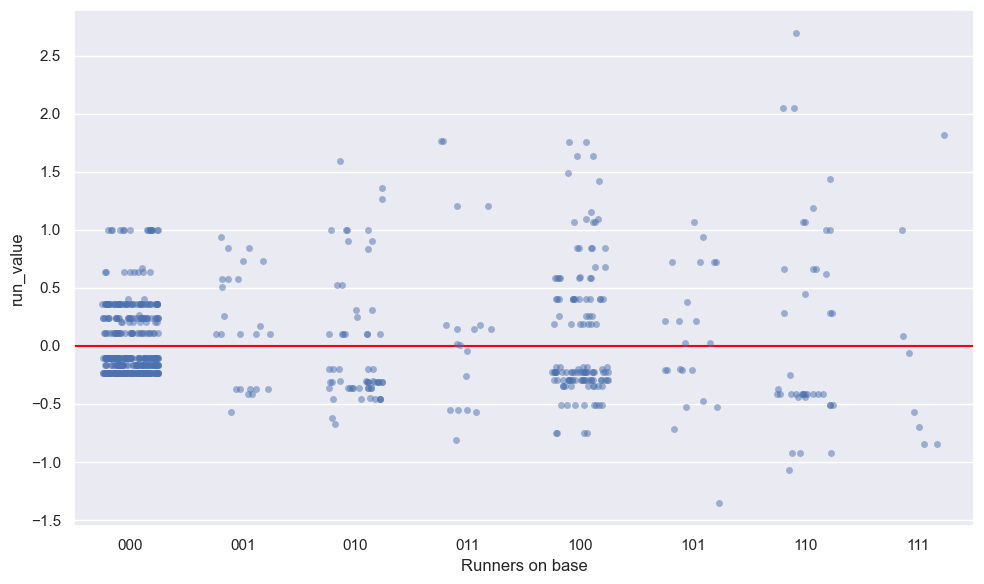

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='darkgrid', palette='deep')

fig, ax = plt.subplots(figsize=(10, 6))

base_order = ['000', '001', '010', '011', '100', '101', '110', '111']

sns.stripplot(data=altuve, x='bases', y='run_value', alpha=0.5, jitter=0.25, ax=ax, order=base_order)

# Add horizontal line at y=0
ax.axhline(y=0, color='red')

# Labels
ax.set_xlabel('Runners on base')
ax.set_ylabel('run_value')

plt.tight_layout()
plt.show()

Plot shows the run values for all Altuve's plate appearances by runners state

### Altuve's 2016 total run production

In [17]:

runs_altuve = altuve.groupby('bases').agg(
    PA=('bases', 'size'),
    total_run_values=('run_value', 'sum')
).reset_index()

runs_altuve


,bases,PA,total_run_values
0,000,417,10.098301
1,001,24,4.060483
2,010,60,0.069487
3,011,18,3.433512
4,100,128,10.193986
5,101,22,1.341679
6,110,40,5.623835
7,111,8,-0.096793


Altuve did not appear to do particularly well with runners in scoring position in 2016.
- 60 PAs with a runner on second base and had a net contribution of 0.7 runs

In [18]:
#Altuve’s total runs contribution for the 2016 season
float(runs_altuve['total_run_values'].sum())

34.72449009958008

## Opportunity and Success for All Hitters

In [19]:
retro2016_bat = retro2016[retro2016['bat_event_fl'] == 'T']

In [20]:
run_exp = retro2016_bat.groupby('bat_id').agg(
    RE24=('run_value', 'sum'),
    PA=('run_value', 'size'),
    runs_start=('rv_start', 'sum')
).reset_index()

In [21]:
run_exp_400 = run_exp[run_exp['PA'] >= 400]
run_exp_400.head(6)

,bat_id,RE24,PA,runs_start
1,abrej003,13.584615,695,336.315363
15,alony001,-5.275563,532,249.240831
17,altuj001,34.724490,717,346.261303
24,andet001,-11.494229,431,205.069635
27,andre001,17.725131,568,256.657091
29,aokin001,-1.909316,467,229.044228


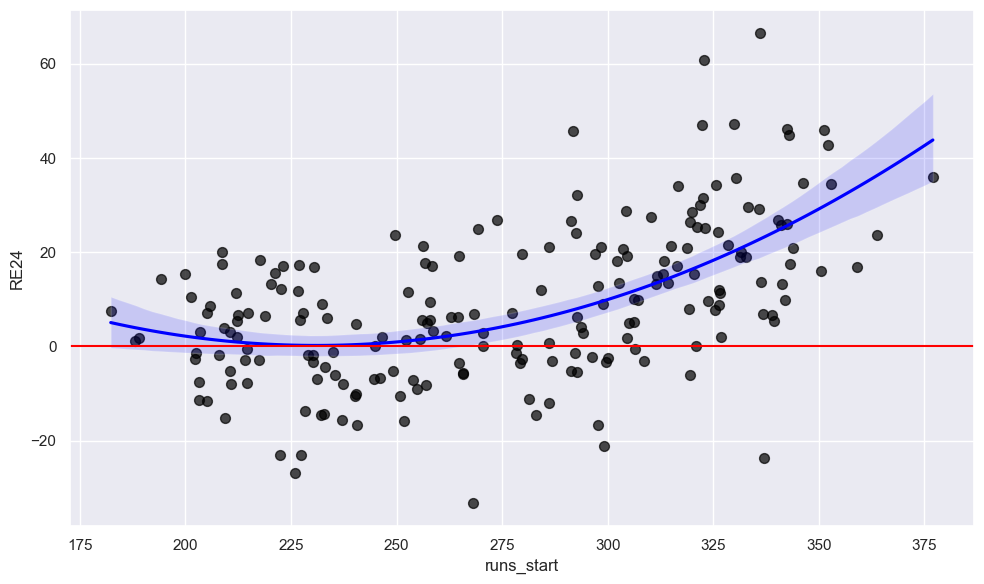

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

# regplot with polynomial fit
sns.regplot(data=run_exp_400, x='runs_start', y='RE24', 
            order=2,
            scatter_kws={'color': 'black', 's': 50, 'alpha': 0.7},
            line_kws={'color': 'blue'},
            ax=ax)

# Add horizontal line
ax.axhline(y=0, color='red')

# Labels
ax.set_xlabel('runs_start')
ax.set_ylabel('RE24')

plt.tight_layout()
plt.show()


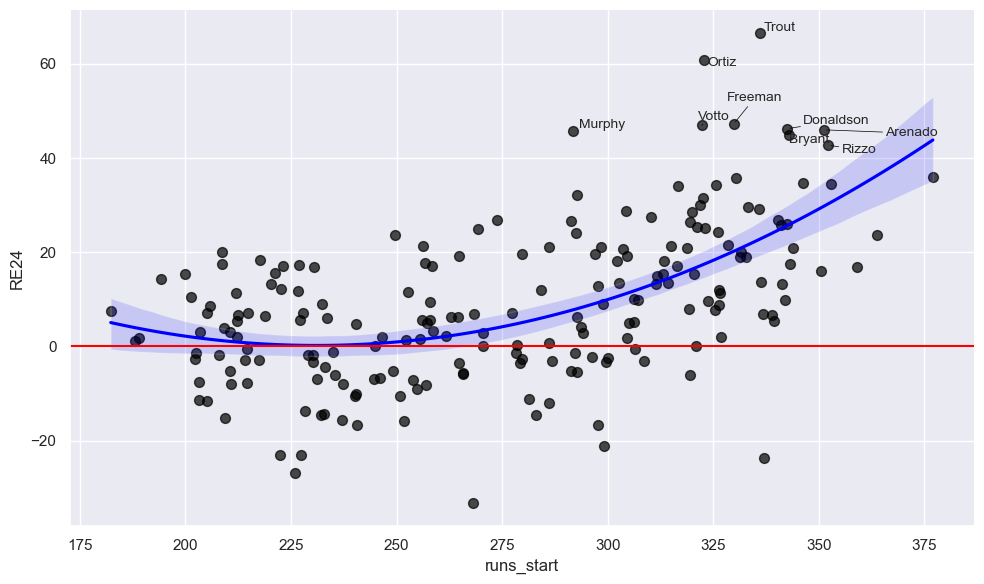

In [ ]:
from adjustText import adjust_text

run_exp_400 = run_exp_400.merge(
    people[['retroID', 'nameLast']], 
    left_on='bat_id', 
    right_on='retroID', 
    how='inner'
)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# regplot with polynomial fit
sns.regplot(data=run_exp_400, x='runs_start', y='RE24', 
            order=2,
            scatter_kws={'color': 'black', 's': 50, 'alpha': 0.7},
            line_kws={'color': 'blue'},
            ax=ax)

# Add horizontal line at y=0
ax.axhline(y=0, color='red')

# Add labels for players with RE24 >= 40
top_players = run_exp_400[run_exp_400['RE24'] >= 40]
texts = []
for idx, row in top_players.iterrows():
    texts.append(ax.text(row['runs_start'], row['RE24'], row['nameLast'], 
                         fontsize=10))

# Automatically adjust text positions to avoid overlaps on plot
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

# Labels
ax.set_xlabel('runs_start')
ax.set_ylabel('RE24')

plt.tight_layout()
plt.show()
